In [1]:
import io
from PIL import Image
import numpy as np
import h5py
import matplotlib.pyplot as plt
from functools import reduce
# import jax

In [2]:
def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype("float32")
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)


def load_trial(hdf5_file_path, FINAL_T):
    flow_arr = []
    depth_arr = []
    image_arr = []
    seg_arr = []
    with h5py.File(hdf5_file_path, "r") as f:
        # extract depth info
        for frame in f["frames"].keys():
            if int(frame) >= FINAL_T:
                break
            flow = np.array(f["frames"][frame]["images"]["_flow_cam0"])
            flow_arr.append(flow)
            depth = np.array(f["frames"][frame]["images"]["_depth_cam0"])
            depth_arr.append(depth)
            image = np.array(
                Image.open(io.BytesIO(f["frames"][frame]["images"]["_img_cam0"][:]))
            )
            image_arr.append(image)
            im_seg = np.array(
                Image.open(io.BytesIO(f["frames"][frame]["images"]["_id_cam0"][:]))
            )
            seg_arr.append(im_seg)
        # flow_arr = np.asarray(flow_arr)
        depth_arr = np.asarray(depth_arr)
        image_arr = np.asarray(image_arr) / 255
        seg_arr = np.asarray(seg_arr)

        # extract object info
        object_ids = np.array(f["static"]["object_ids"])
        object_segmentation_colors = np.array(
            f["static"]["object_segmentation_colors"]
        )
        assert len(object_ids) == len(object_segmentation_colors)

        distractors = (
            np.array(f["static"]["distractors"])
            if np.array(f["static"]["distractors"]).size != 0
            else []
        )
        occluders = (
            np.array(f["static"]["occluders"])
            if np.array(f["static"]["occluders"]).size != 0
            else []
        )
        distractors_occluders = np.concatenate([distractors, occluders])
        if len(distractors_occluders):
            object_ids = object_ids[: -len(distractors_occluders)]
            object_segmentation_colors = object_segmentation_colors[
                : -len(distractors_occluders)
            ]
    rgbds = np.concatenate(
        [image_arr, np.reshape(depth_arr, depth_arr.shape + (1,))], axis=-1
    )
    return (
        rgbds,
        flow_arr,
        seg_arr,
        sorted(object_ids),
        object_segmentation_colors,
    )


In [3]:
# rgbds[0].shape

In [4]:
# flow_arr[0]

In [5]:
# plt.imshow(flow_arr[0])

In [6]:
hdf5_file_path = "/home/haoliangwang/data/physion_hdf5/dominoes_all_movies/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0001.hdf5"
# hdf5_file_path = "/home/haoliangwang/data/physion_hdf5/collide_all_movies/pilot_it2_collision_assorted_targets_box_0003.hdf5"
rgbds, flow_arr, seg_arr, object_ids, object_segmentation_colors = load_trial(hdf5_file_path, 45)


In [7]:
# im_height = im_width = 150
# rgbds_resized = jax.image.resize(
#         rgbds,
#         (rgbds.shape[0], im_height, im_width, *rgbds.shape[3:]),
#         method="linear",
#     )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7372549019607844..0.7098039215686275].


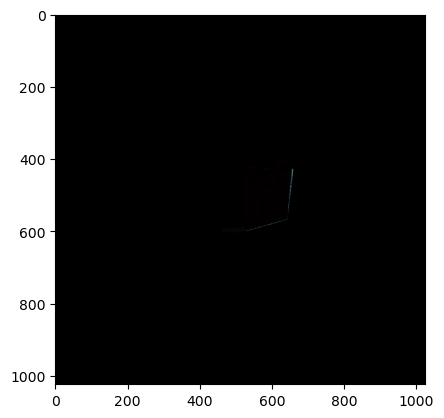

In [8]:
t1 = 14
t2 = 15

plt.imshow(rgbds[t2][...,:3] - rgbds[t1][...,:3])
# plt.imshow(rgbds[t2] - rgbds[t1])

In [12]:
for t2 in range(1, 45):
    print(t2)
    t1 = t2-1
    seg1 = seg_arr[t1]
    seg2 = seg_arr[t2]
    diff = rgbds[t2] - rgbds[t1]
    # diff = rgbds[t2][...,:3] - rgbds[t1][...,:3]
    for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
        mask1 = get_mask_area(seg1, [color])
        area1 = diff[mask1]
        diff_area1 = np.sum(area1)
        mask2 = get_mask_area(seg2, [color])
        area2 = diff[mask2]
        diff_area2 = np.sum(area2)
        if np.abs(diff_area1 + diff_area2) > 100.0:
            print(f"Object {o_id}: {diff_area2 + diff_area1}")

        # fig = plt.figure(figsize=[10, 5])
        # ax = fig.add_subplot(121)
        # ax.imshow(area1)
        # ax = fig.add_subplot(122)
        # ax.imshow(area2)
        # fig.suptitle(f'{diff_area2 + diff_area1}')



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Object 3: -355.01615909454915
16
Object 3: -313.33152265221486
17
Object 3: -109.89374107753508
18
Object 2: -104.60095705986025
Object 3: 111.66126185024495
19
Object 2: -116.9554151983822
Object 3: 230.26728301048297
20
Object 2: -121.29666667826035
Object 3: 373.12218206630047
21
Object 2: -118.43038267902301
Object 3: 548.9409371319939
22
Object 2: -122.51209465195151
Object 3: 776.4019857425317
23
Object 2: -111.1570907265532
Object 3: 962.5086129581227
24
Object 2: -119.2036718938865
Object 3: 1113.034181359235
25
Object 2: -107.74143094829485
Object 3: 1221.503131090426
26
Object 2: -101.37659814778496
Object 3: 1409.5563994239355
27
Object 2: -100.06543566666397
Object 3: 1607.590265683567
28
Object 2: -107.25967102798761
Object 3: 1845.267572880726
29
Object 3: 2054.2142579462015
30
Object 2: -122.81764047005596
Object 3: 2168.249905906004
31
Object 2: -132.8718691956763
Object 3: 2450.5729126285105
32
Object 2: -119.63582028407676
Object 3:

In [9]:
t1 = 14
t2 = 15
seg1 = seg_arr[t1]
seg2 = seg_arr[t2]
diff = rgbds[t2] - rgbds[t1]
# diff = rgbds[t2][...,:3] - rgbds[t1][...,:3]
for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
    mask1 = get_mask_area(seg1, [color])
    area1 = diff[mask1]
    diff_area1 = np.sum(area1)
    mask2 = get_mask_area(seg2, [color])
    area2 = diff[mask2]
    diff_area2 = np.sum(area2)
    print(f"Object {o_id}: {diff_area2 + diff_area1}")

    # fig = plt.figure(figsize=[10, 5])
    # ax = fig.add_subplot(121)
    # ax.imshow(area1)
    # ax = fig.add_subplot(122)
    # ax.imshow(area2)
    # fig.suptitle(f'{diff_area2 + diff_area1}')


Object 1: -1.9921568627451067
Object 2: -16.4392156862745
Object 3: -355.01615909454915


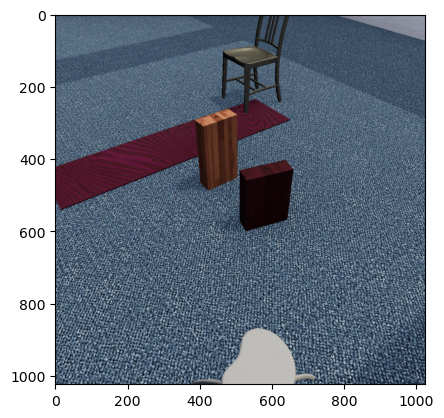

In [10]:
plt.imshow(rgbds[0][...,:3])

In [27]:
rgbds[1][...,:3]-rgbds[0][...,:3]

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ],
        ...,
        [-0.00392157, -0.00392157, -0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157,  0.        ]],

       [[ 0.00392157,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.00392157,  0.00392157,  0.        ],
        ...,
        [ 0.00392157,  0.00392157,  0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157, -0.00392157]],

       [[ 0.00392157,  0.00392157,  0.        ],
        [ 0.        , -0.00392157, -0.00392157],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ],
        [-0.00392157,  0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        , -0.00392157],
        [ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16078431372549018..0.18039215686274512].


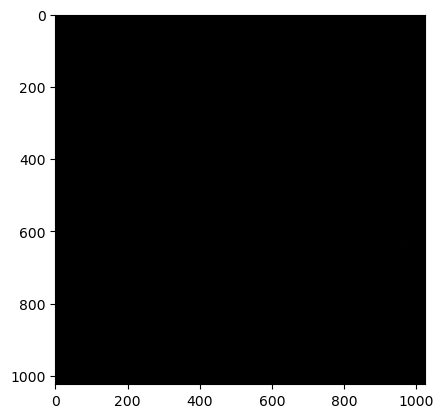

In [22]:
plt.imshow(rgbds[1][...,:3]-rgbds[0][...,:3])

In [12]:
(rgbds[t2] - rgbds[t1]).shape

(1024, 1024, 4)

In [13]:
rgbds[t2] - rgbds[t1]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.00392157,  0.        ,  0.00392157,  0.        ],
        [ 0.00392157,  0.        ,  0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157,  0.        ,  0.        ],
        [ 0.00392157,  0.00392157,  0.        ,  0.        ]],

       [[ 0.        ,  0.        , -0.00392157,  0.        ],
        [ 0.00392157,  0.00392157,  0.00392157,  0.        ],
        [-0.00392157, -0.00392157,  0.        ,  0.        ],
        ...,
        [ 0.00392157,  0.00392157,  0.00392157,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157, -0.00392157, -0.00392157,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00392157,  0.        , -0.00392157,  0.        ],
        [-0.00392157,  0.        ,  0.        ,  0.        ],
        ...,
        [-0.00392157,  0.  

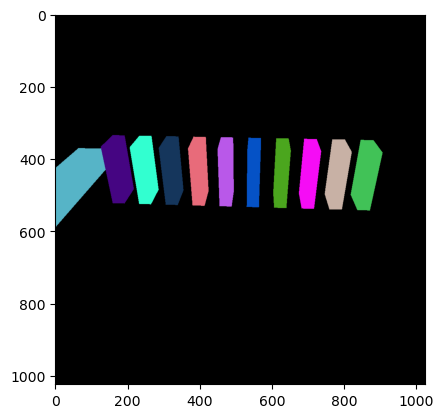

In [14]:
plt.imshow(seg_arr[0])

In [1]:
import os
import h5py
import numpy as np

In [4]:
path = '/home/haoliangwang/data/physion_hdf5/'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.hdf5'):
            with h5py.File(os.path.join(root, file), "r") as f:
                fwait = np.array(f["static"]["push_time"])
                # push_force = np.array(f["static"]["push_force"])
            print(fwait, file)

1 pilot-containment-cone-plate_0031.hdf5
1 pilot-containment-bowl-familiarization_0018.hdf5
1 pilot-containment-bowl_0026.hdf5
1 pilot-containment-multi-bowl_0048.hdf5
1 pilot-containment-cylinder-bowl_0021.hdf5
5 pilot-containment-vase_torus_0033.hdf5
1 pilot-containment-multi-bowl_0029.hdf5
1 pilot-containment-bowl-familiarization_0033.hdf5
5 pilot-containment-vase_torus_0009.hdf5
1 pilot-containment-multi-bowl_0025.hdf5
5 pilot-containment-vase_torus_0043.hdf5
5 pilot-containment-vase_torus_0031.hdf5
1 pilot-containment-bowl-familiarization_0026.hdf5
5 pilot-containment-vase_torus_0032.hdf5
1 pilot-containment-torus_0022.hdf5
1 pilot-containment-bowl-familiarization_0024.hdf5
1 pilot-containment-bowl-familiarization_0035.hdf5
1 pilot-containment-bowl_0000.hdf5
1 pilot-containment-cylinder-bowl_0010.hdf5
5 pilot-containment-vase_0000.hdf5
1 pilot-containment-cylinder-bowl_0028.hdf5
1 pilot-containment-cylinder-bowl_0026.hdf5
1 pilot-containment-multi-bowl_0042.hdf5
1 pilot-containmen